In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gzip

In [2]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

# Import the datasets 

**Instacart datasets** (provided) : https://www.instacart.com/datasets/grocery-shopping-2017 . After loading the datasets, we verified if there were any missing values

In [5]:
products = pd.read_csv('data/products.csv', sep=',')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
products.isnull().values.any()

False

In [7]:
aisles = pd.read_csv('data/aisles.csv', sep=',')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [8]:
aisles.isnull().values.any()

False

In [9]:
departments = pd.read_csv('data/departments.csv', sep=',')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
departments.isnull().values.any()

False

In [11]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
orders.isnull().values.sum()==orders['days_since_prior_order'].isnull().values.sum()

True

The missing values in _orders_ correspond to the date of "previous order", when it happens to be the first one.

In [13]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [14]:
history.isnull().values.any()

False

There are no unexpected missing values in any of the Instacart datasets.

Add the names of the aisle and department in the _products_ dataset, instead of the ID, by merging the datasets :

In [15]:
products_litteral = pd.merge(pd.merge(products, aisles, on='aisle_id'), departments, on='department_id').drop(['aisle_id', 'department_id'], axis=1)
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


Visualize the products per aisle and per department to detect any inconsistency

In [16]:
per_aisle=products_litteral[['product_id', 'aisle']].groupby('aisle').count().sort_values(by='product_id', ascending=False)

<Figure size 1440x720 with 0 Axes>

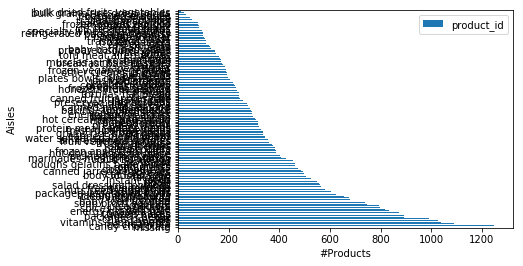

In [27]:
plt.figure(figsize=[20,10])  ##je n'ai pas reussi a rendre l'echelle y lisible...
ax = per_aisle.plot(kind='barh')
ax.set_xlabel('#Products')
ax.set_ylabel('Aisles')
plt.show()

In [50]:
per_aisle.head()

,product_id
aisle,
missing,1258
candy chocolate,1246
ice cream ice,1091
vitamins supplements,1038
yogurt,1026


In [28]:
per_dpt=products_litteral[['product_id', 'department']].groupby('department').count().sort_values(by='product_id', ascending=False)

Text(0, 0.5, 'Departments')

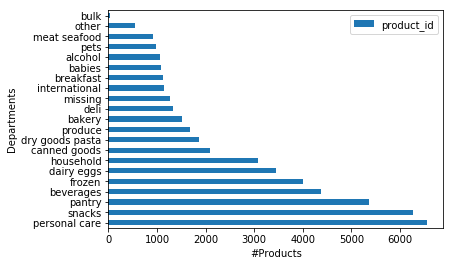

In [29]:
ax = per_dpt.plot(kind='barh')
ax.set_xlabel('#Products')
ax.set_ylabel('Departments')

In [31]:
per_dpt.head()

,product_id
department,
personal care,6563
snacks,6264
pantry,5371
beverages,4365
frozen,4007


We can see many products don't have any name for the aisle and/or department

In [35]:
missing = products_litteral[(products_litteral.department =='missing') | (products_litteral.aisle=='missing')]
missing.head()

,product_id,product_name,aisle,department
42813,38,Ultra Antibacterial Dish Liquid,missing,missing
42814,72,Organic Honeycrisp Apples,missing,missing
42815,110,Uncured Turkey Bologna,missing,missing
42816,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",missing,missing
42817,417,Classics Baby Binks Easter Chocolate Bunny,missing,missing


In [40]:
missing.shape[0]

1258

In [41]:
missing.shape[0]/products_litteral.shape[0]*100

2.5317984221542424

1258 produits (sur 49688 soit 2.53%) ne sont pas catégorisés. Est ce qu'on les enlève ? Ou on utilise le dataset Amazon pour essayer de compléter ? Ou un autre ?
Ca a l'air assez bien réparti comme produits, assez random donc j'aurais tendance à dire de les laisser

**Amazon dataset** : _metadata_ and _reviews_ of Grocery and Gourmet Food products

In [42]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [43]:
Amazon_meta = spark.read.json("../meta_Grocery_and_Gourmet_Food.json.gz")
Amazon_meta.take(2)

[Row(also_buy=None, also_view=['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY'], asin='0681727810', brand='Ariola Imports', category=['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda'], date=None, description=['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.'], details=None, feature=None, fit=None, image=None, main_cat='Grocery', price='$41.91', rank='165,181inGroceryGourmetFood(', similar_item=None, tech1=None, title='Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs'),
 Row(also_buy=['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2', 'B019PHEIVA', 'B019QNGPSW', 'B0041RGD0E', '0998089508', '0988775115', 'B0006Z7NNG', 'B00MU73UKS', 

In [46]:
Amazon_meta.printSchema()

root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- also_view: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: string (nullable = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: string (nullable = true)
 |-- feature: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fit: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- main_cat: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- similar_item: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- asin: string (nullable = true)
 |    |    |-- features: struct (nullabl